# Anomaly Detection

## Using Decision Trees for Anomaly Detection

Decision Trees or CART models are widely used estimation techniques in the field of machine learning, applicable to both classification and regression problems. They approximate data using a step function constructed by iteratively partitioning the observation space based on threshold values of the model's variables, as illustrated in the example below. In each partition, the algorithm identifies subsets of data characterized by very similar target variable values. For regression problems, the partition is determined by calculating the mean of the values, while for classification problems, the dominant class within each subset is assigned.

### Example

The purpose of this program is to demonstrate how decision trees can be used to partition and model data that exhibit a noisy, step-like pattern. The program generates synthetic data that follows a piecewise-constant function with added Gaussian noise, fits a decision tree regressor to approximate this underlying function, and then visualizes the results in a multi-panel layout. In the top row, one plot displays the raw, noisy data, while a second plot shows the tree's piecewise-constant predictions overlaid on the data along with vertical dashed lines indicating where the splits occur. Below these, a third plot presents the decision tree's structure in a classical diagram format, providing insight into the internal decision-making process of the model.

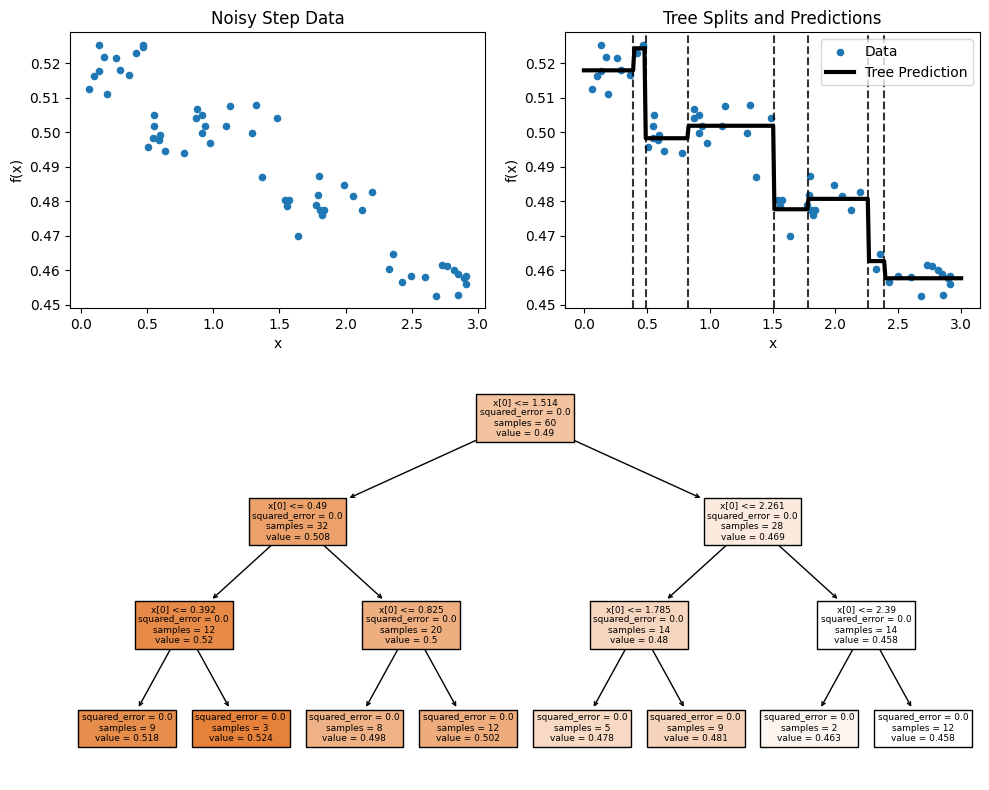

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import _tree

# ---------------------------------------------------
# 1. Generate Step-Like Data with Noise
# ---------------------------------------------------
np.random.seed(42)                  # For reproducibility
n_points = 60                       # Number of data points
X = np.sort(3 * np.random.rand(n_points))  # X in [0, 3], sorted for nicer plotting

# Manually define breakpoints and corresponding "step" levels
breakpoints = [0.5, 1.5, 2.2]       # Positions where the underlying function changes
levels     = [0.52, 0.50, 0.48, 0.46]  # Four levels for four intervals

def true_step_function(x):
    """Return the piecewise-constant step value based on breakpoints."""
    if x < breakpoints[0]:
        return levels[0]
    elif x < breakpoints[1]:
        return levels[1]
    elif x < breakpoints[2]:
        return levels[2]
    else:
        return levels[3]

# Generate the y-values by applying the step function plus some Gaussian noise
y = np.array([true_step_function(xi) for xi in X])
noise = np.random.normal(loc=0.0, scale=0.005, size=n_points)
y += noise

# ---------------------------------------------------
# 2. Fit a Decision Tree to the Noisy Step Data
# ---------------------------------------------------
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X.reshape(-1, 1), y)

# ---------------------------------------------------
# 3. Set up a GridSpec for Three Subplots:
#    Top Row:    (Left)  Data Only
#                (Right) Data + Tree Fit
#    Bottom Row:         Classical Tree Diagram
# ---------------------------------------------------
fig = plt.figure(figsize=(10, 8))

# Create a 2x2 grid, where the bottom subplot spans both columns
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

ax1 = fig.add_subplot(gs[0, 0])       # Top-left
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Top-right (shares y-axis with ax1)
ax3 = fig.add_subplot(gs[1, :])       # Bottom row, spanning both columns

# ---------------------------------------------------
# 4. Left Subplot: Scatter Plot of the Raw Data
# ---------------------------------------------------
ax1.scatter(X, y, s=20, color='C0')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.set_title("Noisy Step Data")

# ---------------------------------------------------
# 5. Right Subplot: Data + Tree's Predicted Step Function
# ---------------------------------------------------
ax2.scatter(X, y, s=20, color='C0', label='Data')

# Generate a dense grid of x-values and predict using the trained tree
x_grid = np.linspace(0, 3, 300)
y_pred = tree.predict(x_grid.reshape(-1, 1))

# Plot the tree’s piecewise-constant predictions as a black line
ax2.plot(x_grid, y_pred, color='black', linewidth=3, label='Tree Prediction')

# Extract the Tree's Split Positions (Thresholds) and Plot Vertical Dotted Lines
thresholds = []
def recurse(node):
    if tree.tree_.feature[node] != _tree.TREE_UNDEFINED:
        thresholds.append(tree.tree_.threshold[node])
        recurse(tree.tree_.children_left[node])
        recurse(tree.tree_.children_right[node])
recurse(0)

thresholds = sorted(set(thresholds))
for t in thresholds:
    ax2.axvline(x=t, color='black', linestyle='--', alpha=0.8)

ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title("Tree Splits and Predictions")
ax2.legend(loc='best')

# ---------------------------------------------------
# 6. Bottom Subplot: Classical Representation of the Tree
# ---------------------------------------------------
ax3.set_title("Decision Tree Structure")
plot_tree(tree, filled=True, ax=ax3)

plt.tight_layout()
plt.show()

Decision trees are a widely used algorithm in practice and are frequently cited in the literature due to the significant advantages they offer over other machine learning techniques. They are among the most informative models because their simple logical structure makes it easy to communicate the underlying rules and to highlight the main factors involved in the estimation process. Moreover, decision trees serve as an excellent automatic method for reducing data dimensionality by selecting only the most important variables for approximating the data. Another advantage of this model is its low computational complexity, even when dealing with a large number of observations and variables. For this reason, CART models are often employed as a fundamental component in various ensemble techniques, such as Random Forest.

## Outlier Detection with Isolation Forest

### The Connection between Trees and Partioning

In machine learning, a tree is used to break down a complex decision into a series of simple questions. Imagine you have a big area (your data space) and you want to split it into smaller regions where each region represents a decision or a prediction. A decision tree does this by asking questions like “Is feature A less than a certain value?” or “Is feature B greater than a threshold?” At each node, the answer to the question partitions the data into two parts. The process is repeated on each part, creating a tree-like structure where the leaves (end points) represent final decisions or predictions.

For example, if you have a dataset with two features (say x and y), the tree might first split the data along the x-axis at x = 0.5. Then, for each side of the split, it might further divide the data along the y-axis. In the end, each small region of the space is associated with a particular class or output.

Here is a simple Python example using scikit-learn to demonstrate this idea with a decision tree classifier:

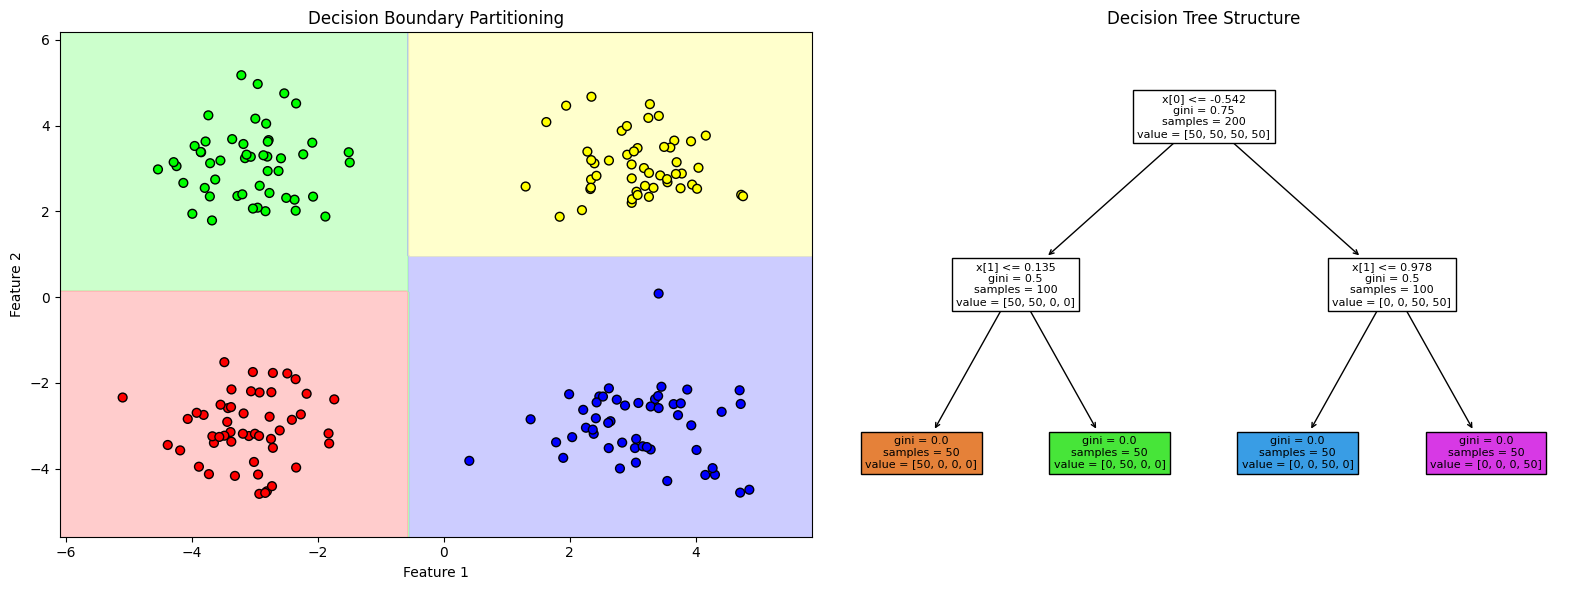

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap

# Define centers for 4 clusters (one per quadrant)
centers = np.array([[-3, -3], [-3, 3], [3, -3], [3, 3]])

# Generate a dataset with 4 clusters
X, y = make_blobs(n_samples=200, centers=centers, cluster_std=0.8, random_state=42)

# Create and train a decision tree classifier with max_depth=2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X, y)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict class labels for each point in the mesh grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color maps for 4 classes
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFAA'])
cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FFFF00'])

# Create a figure with two subplots:
#  - The left subplot will display the decision boundaries
#  - The right subplot will display the decision tree structure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Plot the decision boundaries and data points
axes[0].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].set_title("Decision Boundary Partitioning")

# Right subplot: Plot the decision tree structure
plot_tree(clf, filled=True, ax=axes[1])
axes[1].set_title("Decision Tree Structure")

plt.tight_layout()
plt.show()

In this example, the decision tree classifier automatically finds the best places to split the data (the partitioning). The resulting plot shows regions of the feature space in different colors; each region corresponds to a series of splits (or decisions) that the tree has made. This visual representation shows how the tree partitions the data space into simpler regions to make a prediction, mirroring the way we can recursively divide a space to isolate specific points.

### Random Space Partitioning for Point Isolation

The following code demonstrates how to recursively partition a two-dimensional space to isolate a specific point from a set of randomly generated data points. It starts by using NumPy to generate 200 points from a standard 2D Gaussian distribution and sets a random seed to ensure that the results are reproducible. The code then selects a target point; by default, it automatically chooses the point that is farthest from the origin (0,0), although there are commented alternatives that allow manual selection or choosing the point closest to a specific coordinate.

The core of the program is a recursive function named "isolate_point." This function takes the current bounds of the space, along with the dataset and the target point, and then randomly chooses an axis (either x or y) to split the current region. It picks a random value within the selected axis’ bounds and draws a red partition line on the plot. The function then adjusts the bounds to focus on the side of the split that contains the target point and calls itself recursively. This process continues until the region being considered contains only the target point or a maximum recursion depth is reached, which prevents infinite recursion.

After defining the function, the code sets up the overall bounds of the data, creates a plot showing all data points in blue, and highlights the target point in red. It then initiates the recursive partitioning process, which is visually represented by the red partition lines. Finally, an annotation is added to label the target point, the plot is displayed, and the program prints the number of recursive steps taken.

Overall, the purpose of this code is to provide a visual and practical demonstration of recursive space partitioning. It helps illustrate how a recursive algorithm can be used to progressively narrow down a search area until a specific element is isolated, a concept that is applicable in various fields such as machine learning, computational geometry, and data visualization.

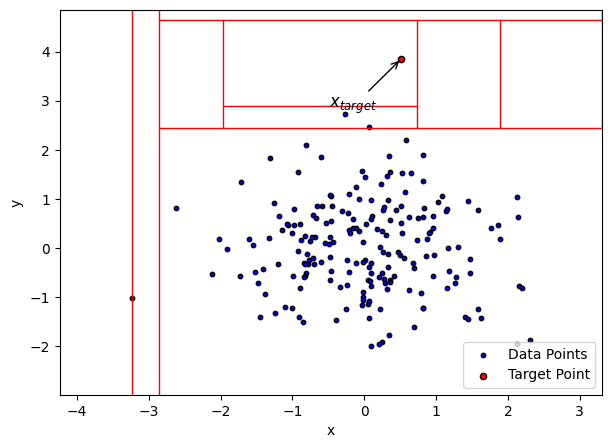

10


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed to ensure reproducibility
np.random.seed(42)

# Generate 200 points from a standard 2D Gaussian (normal) distribution
X = np.random.randn(200, 2)

# --- Select Target Point ---

# Option 1: Automatically select the point farthest from the origin (0,0)
distances = np.linalg.norm(X, axis=1)  # Compute Euclidean distances from the origin
target_idx = np.argmax(distances)  # Index of the farthest point
target_point = X[target_idx]  # Store the farthest point

# Option 2: Manually specify a target point (default: index 20)
#target_idx = 20
#target_point = X[target_idx]

# Option 3 (commented): Select the point closest to a specific location
# specific_point = np.array([-0.25, 2.8])
# distances = np.linalg.norm(X - specific_point, axis=1)
# target_idx = np.argmin(distances)
# target_point = X[target_idx]

# Initialize the recursion counter
n_runs = 0

def isolate_point(ax, X, target_idx, bounds, depth=0, max_depth=20):
    """
    Recursively partitions the space until the target point is isolated.
    
    Parameters:
        ax        : Matplotlib Axes object for visualization.
        X         : The dataset (numpy array of shape [n_samples, 2]).
        target_idx: Index of the target point in X.
        bounds    : Current region as [(x_min, x_max), (y_min, y_max)].
        depth     : Current recursion depth.
        max_depth : Maximum depth to avoid infinite recursion.
    """
    global n_runs
    n_runs += 1  # Track the number of recursion steps

    # Identify points within the current partitioned region
    in_bounds = np.where(
        (X[:, 0] >= bounds[0][0]) & (X[:, 0] <= bounds[0][1]) &  # X-axis constraint
        (X[:, 1] >= bounds[1][0]) & (X[:, 1] <= bounds[1][1])    # Y-axis constraint
    )[0]
    
    # Termination conditions
    if len(in_bounds) == 1 and in_bounds[0] == target_idx:
        return  # The target point is isolated
    if depth >= max_depth:
        return  # Prevent excessive recursion

    # Randomly choose an axis to split (0 for x-axis, 1 for y-axis)
    feature = np.random.choice([0, 1])
    
    # Extract current min and max values for the chosen axis
    current_min, current_max = bounds[feature]

    # Ensure we can split the region
    if current_min == current_max:
        return

    # Select a random split value within the range
    split_val = np.random.uniform(current_min, current_max)

    # Draw the partition line (red)
    if feature == 0:  # Vertical split along x-axis
        ax.plot([split_val, split_val], bounds[1], 'r', lw=1)
    else:  # Horizontal split along y-axis
        ax.plot(bounds[0], [split_val, split_val], 'r', lw=1)

    # Adjust the region that contains the target point
    new_bounds = [list(bounds[0]), list(bounds[1])]
    target_value = X[target_idx, feature]  # Target value on the chosen axis
    
    if target_value < split_val:
        new_bounds[feature][1] = split_val  # Reduce upper bound
    else:
        new_bounds[feature][0] = split_val  # Increase lower bound

    # Convert new_bounds back to tuples for consistency
    new_bounds = [(new_bounds[0][0], new_bounds[0][1]), (new_bounds[1][0], new_bounds[1][1])]

    # Recursively call the function with the new partitioned space
    isolate_point(ax, X, target_idx, new_bounds, depth + 1, max_depth)

# --- Initialize the Full Region ---

# Define the overall bounding box (extend min and max values slightly)
x_min, x_max = np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1
y_min, y_max = np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1
initial_bounds = [(x_min, x_max), (y_min, y_max)]

# --- Visualization Setup ---

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 5))

# Scatter plot of all points (blue)
ax.scatter(X[:, 0], X[:, 1], c='blue', edgecolors='k', s=10, label="Data Points")

# Highlight the target point (red)
ax.scatter(target_point[0], target_point[1], c='red', edgecolors='k', s=20, label="Target Point")

# Begin recursive space partitioning to isolate the target point
isolate_point(ax, X, target_idx, initial_bounds)

# Annotate the target point with an arrow and label
ax.annotate(r'$x_{target}$', xy=(target_point[0], target_point[1]),
            xytext=(target_point[0]-1, target_point[1]-1),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

# Set plot limits and axis labels
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

# Show the final plot
plt.show()

# Print the number of recursion steps taken
print(n_runs)


Both this program and the Isolation Forest algorithm use the idea of isolating points through random partitioning of the feature space. In Isolation Forest, trees are built by randomly selecting a feature and a split value to partition the data. Anomalies are isolated in fewer steps because they lie in sparse regions, making them easier to separate from the rest of the data. Similarly, in this program, the recursive function repeatedly splits the space until only the target point remains in the current partition. The number of splits required can be thought of as analogous to the path length in an Isolation Forest tree, which is used to score points based on how quickly they are isolated. In essence, this program illustrates a simplified version of the underlying principle behind Isolation Forest, where random partitions help to "isolate" a point, revealing how distinct or anomalous it might be compared to the rest of the dataset.

### Isolation Forest

Isolation Forest is an efficient technique for anomaly detection, particularly well-suited for multi-dimensional datasets. Developed by Liu, Ting, and Zhou in 2009, it is a variation of the Random Forest algorithm designed specifically for the task of isolating anomalous points within a dataset. 

The fundamental idea behind Isolation Forest is that anomalies are easier to isolate than normal observations. The algorithm achieves this by constructing multiple decision trees, called isolation trees, where each feature is randomly selected and partitioned at a randomly chosen threshold. This process continues recursively until each data point is isolated in a separate node.


A key concept in this method is the **path length**, which represents the number of splits required to isolate a particular observation. **Anomalies tend to have shorter path lengths since they are more easily separated from the rest of the data, whereas normal observations require more splits to be fully isolated**. The final anomaly score for a given observation is obtained by averaging its path lengths across all trees in the forest. If an observation consistently exhibits a shorter path length across multiple trees, it is likely to be an outlier.

Once the model has been trained on a dataset without anomalies, new observations can be assessed based on how quickly they are isolated within the existing trees. Observations with shorter average path lengths are classified as anomalies, while those requiring a greater number of partitions are considered normal.

### Implementation Example in Python

This program is designed to demonstrate how an Isolation Forest can be used for anomaly detection by training it on a set of data containing two distinct clusters and then testing it on new observations that include both regular data points and potential outliers. The overall purpose is to illustrate how the Isolation Forest identifies anomalies, how its decision function behaves across the feature space, and how these results can be visualized.

The program begins by importing the necessary libraries: NumPy for numerical operations, Matplotlib for plotting, and the IsolationForest model from scikit-learn's ensemble module for detecting anomalies. To ensure that the results are reproducible, a random number generator is initialized using a fixed seed with NumPy's RandomState. Training data is generated next by creating two clusters. The first cluster is centered at (-2, -2) and is formed by scaling normally distributed random numbers by 0.3 and shifting them by -2 in each dimension. The second cluster is similarly created but centered at (2, 2) by scaling and shifting in the opposite direction. These two clusters are then combined vertically into a single training set. Afterward, new test data is generated to evaluate the model. This test set comprises two types of points: regular points that mimic the two clusters (50 points from each cluster) and outlier points that are uniformly distributed over a larger range. These outlier points are expected to be flagged by the Isolation Forest as anomalies. The regular and abnormal observations are then merged into a single test dataset.

Once the data is prepared, an Isolation Forest model is instantiated with a contamination rate set to 0.05, meaning the model expects about 5% of the data to be anomalies. The model is trained on the previously generated training data. After training, the model predicts labels for the new test data, returning 1 for regular (inlier) points and -1 for anomalous (outlier) points. The test data is then separated into regular points and outlier points based on these predictions.

For visualization purposes, a grid spanning the feature space from -5 to 5 in both x and y directions is created using a mesh grid. The Isolation Forest's decision function, which quantifies how anomalous a point is (with lower scores indicating higher anomaly likelihood), is computed over this grid. The resulting scores are reshaped to match the grid dimensions so that they can be displayed as a contour plot.

Finally, the program creates a plot where the decision function is visualized as a filled contour plot with a blue colormap. The training data points are plotted as circles with no fill (only edges) to distinguish them, while the new regular observations are plotted in green and the abnormal observations in red. A legend and title are added to provide clarity, and the final plot is displayed. Below is the code with detailed inline comments that explain each step of the process.

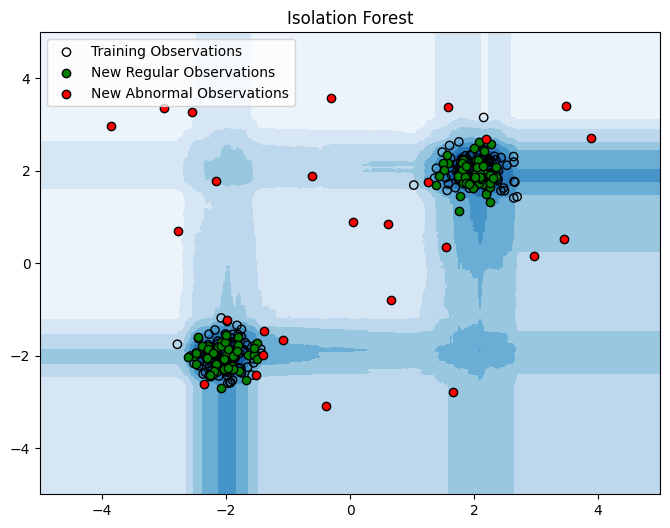

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility
rng = np.random.RandomState(42)

# Generate training data: two clusters
X1_train = 0.3 * rng.randn(100, 2) - [2, 2]  
X2_train = 0.3 * rng.randn(100, 2) + [2, 2]  
X_train = np.vstack((X1_train, X2_train))  

# Generate new test data: a mix of regular points and anomalies
X_regular = 0.3 * rng.randn(50, 2) - [2, 2]  
X_regular = np.vstack((X_regular, 0.3 * rng.randn(50, 2) + [2, 2]))

X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))  
X_test = np.vstack((X_regular, X_outliers))  

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict new data points
y_pred_test = iso_forest.predict(X_test)

# Separate points based on prediction
regular_points = X_test[y_pred_test == 1]
outlier_points = X_test[y_pred_test == -1]

# Create a grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(-5, 5, 300), np.linspace(-5, 5, 300))
Z = iso_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot results
plt.figure(figsize=(8, 6))

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap=plt.cm.Blues)

# Plot training observations
plt.scatter(X_train[:, 0], X_train[:, 1], edgecolors='k', facecolors='none', label="Training Observations")

# Plot new regular observations
plt.scatter(regular_points[:, 0], regular_points[:, 1], c='green', edgecolors='k', label="New Regular Observations")

# Plot new abnormal observations
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], c='red', edgecolors='k', label="New Abnormal Observations")

plt.title("Isolation Forest")
plt.legend()
plt.show()

### **Analysis of Results**

The resulting visualization highlights three types of observations: the original training data, shown in black; new observations classified as normal, displayed in green; and anomalies, marked in red. The algorithm effectively isolates outliers due to their distinct behavior in the partitioning process. 

In the context of banking and finance, Isolation Forest has practical applications in fraud detection, financial transaction monitoring, and the identification of irregularities in market data. By leveraging its ability to distinguish between normal and anomalous patterns, financial institutions can enhance their risk assessment frameworks and improve the detection of fraudulent activities.

## Self-Organizing Maps (Kohonen Networks) for Anomaly Detection

### Theoretical Foundations

Self-Organizing Maps are a type of unsupervised neural network introduced by Teuvo Kohonen in the 1980s. Unlike traditional feedforward neural networks that are used for classification or regression tasks, SOMs are primarily used for clustering and visualization. Their structure consists of a grid (or lattice) of neurons, each associated with a weight vector of the same dimensionality as the input data. The key idea behind SOMs is to map high-dimensional input data onto a lower-dimensional (typically two-dimensional) grid while preserving the topological properties of the data. This means that similar data points in the input space tend to be mapped to nearby neurons on the grid.

The SOM algorithm consists of three principal phases: initialization, training, and mapping. During the initialization phase, the weight vectors are typically assigned small random values or are sampled from the input data. In the training phase, the network learns by iteratively presenting input vectors and adjusting the weights of the neurons. This process is driven by a competitive learning mechanism where, for each input, the neuron whose weight vector is closest to the input (usually determined by Euclidean distance) is identified as the "winning neuron" or Best Matching Unit (BMU). Once the BMU is determined, not only is its weight updated to move closer to the input, but so are the weights of neurons within a defined neighborhood around the BMU. The size of this neighborhood decreases over time, leading to a fine-tuning of the mapping. In the final mapping phase, each input is assigned to the neuron with the closest weight vector, thus providing a low-dimensional representation of the original data.

### Functioning of a Self-Organizing Map

The training of a SOM involves several key steps. Consider an input vector $ \mathbf{x} \in \mathbb{R}^n $ and a set of neurons $ \{i\} $ arranged in a two-dimensional grid, each with an associated weight vector $ \mathbf{w}_i \in \mathbb{R}^n $. The algorithm proceeds as follows:

1. **Initialization:**  
   The weight vectors $ \mathbf{w}_i $ are initialized, either randomly or by using samples from the input space. This initialization provides a rough approximation of the data distribution.

2. **Competition:**  
   For each input vector $ \mathbf{x} $, the distance between $ \mathbf{x} $ and every weight vector $ \mathbf{w}_i $ is computed. The Euclidean distance is commonly used:
   $$
   d_i = \|\mathbf{x} - \mathbf{w}_i\|
   $$
   The neuron with the smallest distance is identified as the Best Matching Unit (BMU).

3. **Cooperation:**  
   A neighborhood function, typically a Gaussian, defines the degree to which neurons close to the BMU will be updated. This function decreases with distance from the BMU and evolves over time:
   $$
   h_{ci}(t) = \exp\left(-\frac{\|r_c - r_i\|^2}{2\sigma(t)^2}\right)
   $$
   where $ r_c $ and $ r_i $ denote the positions of the BMU and the $ i $-th neuron on the grid, respectively, and $ \sigma(t) $ is the neighborhood radius at time $ t $.

4. **Adaptation:**  
   The weight vectors are updated according to the rule:
   $$
   \mathbf{w}_i(t+1) = \mathbf{w}_i(t) + \alpha(t) \, h_{ci}(t) \, (\mathbf{x} - \mathbf{w}_i(t))
   $$
   where $ \alpha(t) $ is the learning rate that decays over time. Through repeated iterations, the network organizes itself such that neurons become sensitive to different regions of the input space, and similar inputs are mapped to nearby neurons.

This process results in a topologically ordered map that captures the structure of the data in a visually interpretable form. The final map can be analyzed using tools such as the U-matrix, which visualizes the distances between neighboring neurons, highlighting clusters and boundaries within the data.

### Anomaly Detection in Finance

Anomaly detection in finance is a critical task for identifying fraudulent transactions, detecting market irregularities, and managing risk. The ability of SOMs to provide a low-dimensional representation of complex financial datasets makes them particularly useful for this purpose. In a financial context, anomalies are often characterized by their deviation from normal patterns. When a SOM is trained on historical financial data, most normal data points will map to neurons that are part of well-defined clusters, while anomalous points—due to their distinct characteristics—tend to be mapped to areas of the grid that are sparsely populated or have high quantization error.

The quantization error, defined as the distance between an input vector and its BMU’s weight vector, serves as an effective metric for anomaly detection. High quantization errors indicate that an input does not fit well into any of the learned clusters, suggesting that it may be an outlier. Furthermore, visualization of the SOM using the U-matrix allows practitioners to identify regions of the map where data points are more dissimilar. In these regions, the probability of encountering anomalies is higher.

In the realm of finance, where datasets often contain millions of transactions with complex interdependencies, SOMs provide a means of reducing dimensionality while preserving the inherent structure of the data. This capability is invaluable for real-time anomaly detection in applications such as credit card fraud monitoring and high-frequency trading surveillance.

### Python Examples

Below is a Python example that demonstrates how to train a Self-Organizing Map using the `MiniSom` library and then use it for anomaly detection. In this example, we simulate a financial dataset and use the SOM to identify potential anomalies.

**Example 1: Training a SOM**

Training SOM...


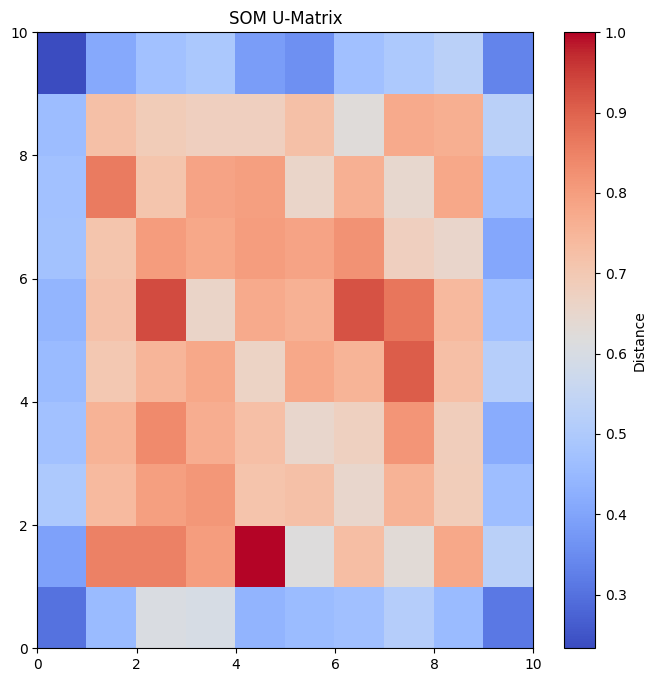

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom

# Simulate financial data: 1000 transactions with 5 features each
np.random.seed(42)
data_normal = np.random.normal(loc=0, scale=1, size=(1000, 5))

# Inject anomalies: 50 abnormal transactions
data_anomalies = np.random.normal(loc=5, scale=0.5, size=(50, 5))
data = np.vstack((data_normal, data_anomalies))

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Define and train the SOM
som_dim = (10, 10)
som = MiniSom(som_dim[0], som_dim[1], data_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
print("Training SOM...")
som.train_random(data_scaled, num_iteration=1000)

# Visualize the SOM using the distance map (U-Matrix)
plt.figure(figsize=(8, 8))
u_matrix = som.distance_map().T  # Transpose for correct orientation
plt.pcolor(u_matrix, cmap='coolwarm')
plt.colorbar(label='Distance')
plt.title("SOM U-Matrix")
plt.show()

In this example, a synthetic dataset representing financial transactions is created. The normal data points are drawn from a standard normal distribution, while the anomalies are generated with a different distribution (with higher mean and lower variance). After scaling the data, a SOM is trained using the MiniSom library, and the U-Matrix is plotted to visualize the topological structure.

**Example 2: Anomaly Detection with SOM**

The quantization error for each data point can be used to flag anomalies. Data points with a quantization error above a certain threshold are considered anomalies.

Number of anomalies detected: 100


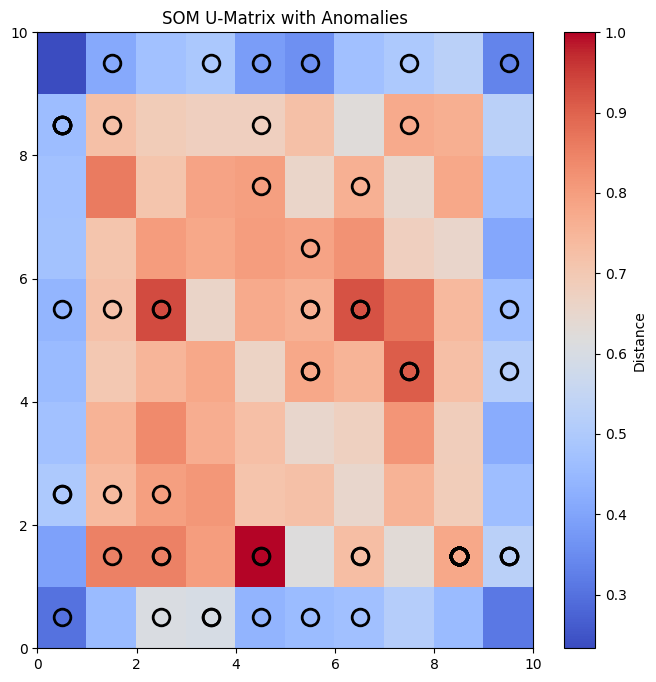

In [32]:
# Compute quantization errors for all data points
quantization_errors = np.array([np.linalg.norm(data_point - som.winner(data_point)[1]) 
                                for data_point in data_scaled])
# Alternatively, we can compute the error as the Euclidean distance between the data point and its BMU
def compute_quantization_error(data_point):
    winner = som.winner(data_point)
    weight_vector = som.get_weights()[winner]
    return np.linalg.norm(data_point - weight_vector)

quantization_errors = np.array([compute_quantization_error(dp) for dp in data_scaled])

# Set a threshold for anomaly detection (e.g., 95th percentile of the quantization errors from normal data)
threshold = np.percentile(quantization_errors[:1000], 95)

# Identify anomalies
anomaly_indices = np.where(quantization_errors > threshold)[0]
print(f"Number of anomalies detected: {len(anomaly_indices)}")

# Visualize the anomalies on the U-Matrix
plt.figure(figsize=(8, 8))
plt.pcolor(u_matrix, cmap='coolwarm')
plt.colorbar(label='Distance')
plt.title("SOM U-Matrix with Anomalies")

# Mark anomalies
for idx in anomaly_indices:
    win = som.winner(data_scaled[idx])
    plt.plot(win[0] + 0.5, win[1] + 0.5, 'ko', markersize=12, markerfacecolor='None', markeredgewidth=2)

plt.show()

In this second example, we compute the quantization error for each data point by measuring the Euclidean distance between the data point and the weight vector of its Best Matching Unit (BMU). A threshold is set based on the 95th percentile of quantization errors from the normal data. Data points with errors above this threshold are flagged as anomalies. Finally, these anomalies are highlighted on the U-Matrix visualization.

In Conclusion, Self-Organizing Maps represent a powerful tool in the field of unsupervised learning, especially in domains like finance where the complexity of data can obscure underlying patterns. Their ability to reduce dimensionality while preserving topological relationships makes them particularly well-suited for anomaly detection. By mapping high-dimensional financial data to a two-dimensional grid, SOMs enable practitioners to visually inspect and quantify deviations from normal behavior. This chapter has outlined both the theoretical underpinnings and practical implementations of SOMs, emphasizing their application in anomaly detection. The provided Python examples illustrate how to train a SOM, visualize the resulting map, and identify anomalies, thereby demonstrating the tangible benefits of integrating SOMs into financial analytics pipelines.

This innovative approach is reshaping the way we understand and manage financial risk, offering a promising avenue for future research and practical deployment in advanced AI-driven finance systems.

## Reference and Credits

Below is a list of classical references that cover decision trees in general, their use in anomaly detection, isolation forests, and self-organizing maps for anomaly detection.

**Decision Trees:**

Quinlan, J. R. (1986). *Induction of decision trees*. Machine Learning, 1, 81–106.  
Breiman, L., Friedman, J., Stone, C. J., & Olshen, R. A. (1984). *Classification and Regression Trees*. Monterey, CA: Wadsworth.

**Decision Trees in Anomaly Detection and Machine Learning:**

Hodge, V. J., & Austin, J. (2004). *A survey of outlier detection methodology*. Artificial Intelligence Review, 22(2), 85–126.  
Chandola, V., Banerjee, A., & Kumar, V. (2009). *Anomaly detection: A survey*. ACM Computing Surveys, 41(3), Article 15.

**Anomaly Detection and Machine Learning:**

Aggarwal, C. C. (2013). *Outlier Analysis*. New York, NY: Springer.  
Pimentel, M. A. F., Clifton, D. A., Clifton, L., & Tarassenko, L. (2014). *A review of novelty detection*. Signal Processing, 99, 215–249.

**Isolation Forest and Anomaly Detection:**

Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). *Isolation Forest*. In 2008 Eighth IEEE International Conference on Data Mining (pp. 413–422). IEEE.

**Self-Organizing Maps for Anomaly Detection:**

Kohonen, T. (2001). *Self-Organizing Maps* (3rd ed.). Berlin, Germany: Springer.  
Vesanto, J., & Alhoniemi, E. (2000). *Clustering of the Self-Organizing Map*. IEEE Transactions on Neural Networks, 11(3), 586–600.  
Kaski, S. (1998). *Data Exploration Using Self-Organizing Maps*. Acta Polytechnica Scandinavica, 40, 1–17.